In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = np.load("/content/drive/MyDrive/IAAIP/dataset/housegan_clean_data.npy", None, True)

*********************************
******* House-GAN Dataset *******
*********************************

This dataset contains 145,811 floorplans in vector format utilized for training House-GAN.
The data is organized in a list format, where each element represents one floorplan.
For each floorplan in the dataset we have the following elements (in order):

1) List of room types: mapping between room types and their corresponding class.
ROOM_CLASS = {"exterior_wall": 0, "living_room": 1, "kitchen": 2, "bedroom": 3, "bathroom": 4, "missing": 5, "closet": 6, "balcony": 7, "corridor": 8, "dining_room": 9, "laundry_room": 10}

2) List of room bounding boxes (INCLUDING FOR THE EXTERIOR WALLS. THESE ARE MODIFIED EDGES WHERE THE X1/Y1 MATCHING COORIDNATE HAS BEEN INCREMENTED BY 1. ENSURE THE POSITION IN ROOM TYPES LIST AND BOUNDING BOX LIST ARE THE SAME): each bounding box is represented by [x0, y0, x1, y1], where (x0, y0) and (x1, y1) are top-left and bottom-right coordinates, respectively.

3) List of floorplan edges: (do not modify, shh) edges in the floorplan are represented by [x0, y0, x1, y1, *, *], where (x0, y0) and (x1, y1) are the edges endpoints and elements * are not being used (internally used by raster-to-vector).

4) Edge to room mapping: for each edge we assign up to 2 rooms sharing that edge, normally we have 2 rooms for internal edges and 1 room for edges in the building footprint, cases with 0 room per edge (should not happen) are likely vectorization/processing errors.

5) Doors to edges list: an element "i" in this list means that the i-th edge contains a door.

6) Vector to RGB mapping: this field contains the name of the original RGB image from LIFULL dataset.

7) TODO: node features

        // Connection features:
        //      0.0 {interior wall angle from src wall to dest wall by right-hand rule}
        //      0.1 {garbage, zeros - this is to make all edges have two features}

8) TODO: edge features

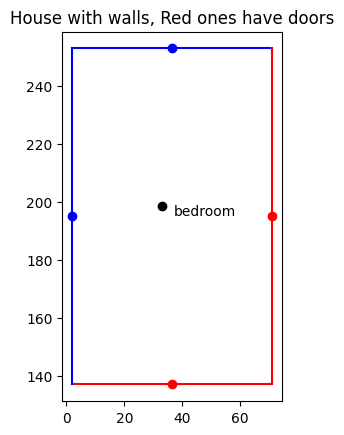

In [4]:
ROOM_CLASS = {1:"living_room", 2:"kitchen", 3:"bedroom", 4:"bathroom", 5:"missing", 6:"closet", 7:"balcony", 8:"corridor", 9:"dining_room", 10:"laundry_room"}

house_nr =

# Retrieve house-specific data
edges = np.array(data[house_nr][2])[:,0:4]
doors = np.array(data[house_nr][4])
rooms = np.array(data[house_nr][1])
room_types = np.array(data[house_nr][0])

# Plotting
fig, ax = plt.subplots()
ax.set_title("House with walls, Red ones have doors")
for num, edge in enumerate(edges):
  x = np.array([edge[0], edge[2]])
  x_avg = np.mean(x)
  y = np.array([edge[1], edge[3]])
  y_avg = np.mean(y)
  if num in doors:
    ax.plot(x,y, "r")
    plt.scatter(x_avg, y_avg, c="#FF0000")
  else:
    ax.plot(x,y, "b")
    plt.scatter(x_avg, y_avg, c="#0000FF")
for num, room in enumerate(rooms):
  center_x = np.mean([room[0],room[2]])
  center_y = np.mean([room[1],room[3]])
  plt.text(center_x, center_y, ROOM_CLASS[room_types[num]])
  plt.scatter(center_x-4, center_y+3, c="#000000")
ax.set_aspect('equal')


In [ ]:
print(data[0])


[[6.0, 2.0, 4.0], [array([132,   6, 148,  65]), array([110,  68, 208, 130]), array([132,  91, 160, 130])], [[108, 89, 130, 89, 8, 0], [108, 66, 130, 66, 0, 8], [108, 66, 108, 89, 8, 0], [209, 66, 209, 131, 0, 8], [130, 4, 149, 4, 0, 6], [130, 89, 161, 89, 8, 4], [130, 4, 130, 66, 6, 0], [149, 4, 149, 66, 0, 6], [130, 89, 130, 131, 4, 0], [161, 89, 161, 131, 2, 4], [130, 66, 149, 66, 6, 8], [149, 66, 209, 66, 0, 8], [130, 131, 161, 131, 4, 0], [161, 131, 209, 131, 8, 0]], [[1], [1], [1], [1], [0], [1, 2], [0], [0], [2], [1, 2], [0, 1], [1], [2], [1]], [6, 7, 9, 2, 3], 'floorplan_high_res/0d/00/464243c9d2ffd5507b24bdced40a/0001.jpg']


In [ ]:
import math
import random
# from shapely.geometry import MultiPoint,Polygon
# from shapely.geometry import Point, MultiPoint


def get_exterior_walls(rooms_connected, edges, doors):
    indices = [i for i, item in enumerate(rooms_connected) if len(item) == 1]
    exterior_walls = [(i,list(edges[i]),1) if i in doors else (i,list(edges[i]),0) for i in indices]
    return exterior_walls

def filter_graphs(rooms_connected, edges, doors):
    exterior_walls = get_exterior_walls(rooms_connected, edges, doors)
    source = exterior_walls[0][1][0:2]
    dest = exterior_walls[0][1][2:4]
    previous_wall = exterior_walls.pop(0)
    while(len(exterior_walls) != 0):
      found = 0
      for i, exterior_wall in enumerate(exterior_walls):
          if np.array_equal(exterior_wall[1][0:2], dest):
            dest = exterior_wall[1][2:4]
            previous_wall = exterior_walls.pop(i)
            source = exterior_wall[1][0:2]
            found = 1
          elif np.array_equal(exterior_wall[1][2:4], dest):
            dest = exterior_wall[1][0:2]
            previous_wall = exterior_walls.pop(i)
            source = exterior_wall[1][2:4]
            found = 1
      if found==0:
        return False
    return True


def get_number_of_specific_room(rooms, room_type):
    unique, counts = np.unique(rooms, return_counts=True)
    dict_counts = dict(zip(unique, counts))
    return dict_counts.get(room_type, 0)

def get_randomised_number(number):
    if number > 0:
      rand_number = random.randint(0,number)
      if rand_number == number:
        plus = False
      else:
        plus = True
      return rand_number, plus
    else:
      return number, False
def get_number_of_living_rooms(rooms):
    number = get_number_of_specific_room(rooms, 1)
    return get_randomised_number(number)

def get_number_of_bedrooms(rooms):
    number = get_number_of_specific_room(rooms, 3)
    return get_randomised_number(number)

def get_number_of_bathrooms(rooms):
    number = get_number_of_specific_room(rooms, 4)
    return get_randomised_number(number)

def calculate_centroid(points):
    x_sum = sum(point[0] for point in points)
    y_sum = sum(point[1] for point in points)
    centroid_x = x_sum / len(points)
    centroid_y = y_sum / len(points)
    return (centroid_x, centroid_y)

def get_next_corner(exterior_wall_coord, corners, corner_points):
    if corner_points.index((exterior_wall_coord[0], exterior_wall_coord[1])) < corner_points.index((exterior_wall_coord[2], exterior_wall_coord[3])):
      return  ((exterior_wall_coord[0], exterior_wall_coord[1]),(exterior_wall_coord[2], exterior_wall_coord[3]))
    else:
      return ((exterior_wall_coord[2], exterior_wall_coord[3]),(exterior_wall_coord[0], exterior_wall_coord[1]))

def calculate_angle(prev_source, prev_dest, source, dest):
    prev_vector = (prev_dest[0] - prev_source[0], prev_dest[1] - prev_source[1])
    vector = (dest[0] - source[0], dest[1] - source[1])
    angle_radians = np.arctan2(vector[1], vector[0]) - np.arctan2(prev_vector[1], prev_vector[0])
    angle_degrees = np.degrees(angle_radians)
    if (angle_degrees > 180):
      angle_degrees = angle_degrees - 360
    if (angle_degrees < -180):
      angle_degrees = angle_degrees + 360
    return angle_degrees

def get_connection_corners(edges, rooms_connected):
    corners = []
    exterior_walls = get_exterior_walls(rooms_connected, edges, doors)

    #I first have to find all the corners to be able to calculate the centroid, so I can make sure I go in a clockwise direction in the polygon
    for i in range(len(exterior_walls) - 1):
      x_i0, y_i0 = exterior_walls[i][1][0], exterior_walls[i][1][1]
      x_i1, y_i1 = exterior_walls[i][1][2], exterior_walls[i][1][3]

      for j in range(i + 1, len(exterior_walls)):
        x_j0, y_j0 = exterior_walls[j][1][0], exterior_walls[j][1][1]
        x_j1, y_j1 = exterior_walls[j][1][2], exterior_walls[j][1][3]

        if x_i0 == x_j0 and y_i0 == y_j0:
          corners.append((exterior_walls[i], exterior_walls[j], (x_i0, y_i0)))
        elif x_i0 == x_j1 and y_i0 == y_j1:
          corners.append((exterior_walls[i], exterior_walls[j], (x_i0, y_i0)))
        elif x_i1 == x_j0 and y_i1 == y_j0:
          corners.append((exterior_walls[i], exterior_walls[j], (x_i1, y_i1)))
        elif x_i1 == x_j1 and y_i1 == y_j1:
          corners.append((exterior_walls[i], exterior_walls[j], (x_i1, y_i1)))



    #[x0, y0, x1, y1]
    #np.arctan2(y,x) so I MUST SWITCH THE INPUT
    corner_points = [corners[i][2] for i in range(len(corners))]
    centroid = calculate_centroid(corner_points)
    corners = sorted(corners, key = lambda x: (math.atan2((x[2][1]-centroid[1]),(x[2][0]-centroid[0])) + 2 * np.pi) % (2 * np.pi), reverse=True)
    sorted_corner_points = [corners[i][2] for i in range(len(corners))]


    # for i in range(len(exterior_walls)):
    #   source, dest = get_next_corner(exterior_walls[i][1], corners, sorted_corner_points)
    #   print(exterior_walls[i][1])
    #   print(source, dest)

    connection_corners = []
    source, dest = get_next_corner(exterior_walls[0][1], corners, sorted_corner_points)
    initial_source, initial_dest = source, dest
    initial_wall = exterior_walls[0]
    previous_wall = exterior_walls.pop(0)
    while(len(exterior_walls) != 0):
        for i, exterior_wall in enumerate(exterior_walls):
            if np.array_equal(exterior_wall[1][0:2], dest):
              connection_corners.append([0, previous_wall[0], 0, exterior_wall[0], calculate_angle(source, dest, exterior_wall[1][0:2], exterior_wall[1][2:4]), 0])
              dest = exterior_wall[1][2:4]
              previous_wall = exterior_walls.pop(i)
              source = exterior_wall[1][0:2]
            elif np.array_equal(exterior_wall[1][2:4], dest):
              connection_corners.append([0, previous_wall[0], 0, exterior_wall[0], calculate_angle(source, dest, exterior_wall[1][2:4], exterior_wall[1][0:2]), 0])
              dest = exterior_wall[1][0:2]
              previous_wall = exterior_walls.pop(i)
              source = exterior_wall[1][2:4]
    connection_corners.append([0, previous_wall[0], 0, initial_wall[0], calculate_angle(source, dest, initial_source, initial_dest), 0])
    # print(*connection_corners, sep="\n")
    return connection_corners

def get_middle_of_room(room_coordinates):
    return [(room_coordinates[0]+room_coordinates[2])/2, (room_coordinates[1]+room_coordinates[3])/2]

def get_cardinal_location(point1, point2):
    angle_radians = np.arctan2(point2[1] - point1[1], point2[0] - point1[0])
    angle_degrees = np.degrees(angle_radians)
    directions = ["E", "NE", "N", "NW", "W", "SW", "S", "SE", "Undefined"]
    index = round(angle_degrees / 45) % 8
    # cardinal_direction = directions[index]
    cardinal_direction = index
    return cardinal_direction

def find_approximate_centroid(room_idx, house_edges, house_edge_adjacencies):
  # room_idx = data[house_nr][0].index(room_type)
  room_edge_ids = [id for id, edge in enumerate(house_edge_adjacencies) if room_idx in edge]
  room_edges = np.array(house_edges)[room_edge_ids]
  # Weight each edge by it's length
  weights = np.linalg.norm(room_edges[:,[2,3]] - room_edges[:,[0,1]], axis=1)**1.5
  # Uncomment below to remove weights
  # weights = np.ones(len(room_edges))
  # print(f"weights:\n {weights}")
  # print(f"roomedges:\n {room_edges}")
  x = np.concatenate([room_edges[:,0].reshape(-1,1), room_edges[:,2].reshape(-1,1)], axis=1)
  x_avg = np.mean(x, axis=1).reshape(-1,1)
  y = np.concatenate([room_edges[:,1].reshape(-1,1), room_edges[:,3].reshape(-1,1)], axis=1)
  y_avg = np.mean(y, axis=1).reshape(-1,1)
  room_edge_midpoints = np.concatenate((x_avg, y_avg), axis=1)
  # print(f"room_edge_midpoints:\n {room_edge_midpoints}")
  room_x, room_y = np.average(room_edge_midpoints, axis = 0, weights=weights)
  return [room_x, room_y]


def get_connection_rooms(rooms_connected, rooms_coordinates, rooms, edges, doors):
    connection_rooms = []
    for index, connection in enumerate(rooms_connected):
      #room + edge
      rand_num = random.randint(1,100)
      # if rand_num < 36:
      if len(connection) == 1:
        room1 = connection[0]
        # room1_middle = get_middle_of_room(rooms_coordinates[room1])
        # wall1_middle = get_middle_of_room(edges[index])
        room1_middle = find_approximate_centroid(room1, edges, rooms_connected)
        wall1_middle = get_middle_of_room(edges[index])
        # print(f"{room1}, edge_index: {index}, {get_cardinal_location(room1_middle, wall1_middle)}")
        if rand_num < 26:
          connection_rooms.append([int(rooms[room1]), room1, 0, index, 1 if index in doors else 0, get_cardinal_location(room1_middle, wall1_middle)])
        else:
          connection_rooms.append([int(rooms[room1]), room1, 0, index, 1 if index in doors else 0, int(8)])
      #room + room
      if len(connection) == 2:
        room1 = connection[0]
        room1_middle = find_approximate_centroid(room1, edges, rooms_connected)
        room2 = connection[1]
        room2_middle = find_approximate_centroid(room2, edges, rooms_connected)
        # print(f"card_loc: rooms:{room1}, {room2}, {get_cardinal_location(room1_middle, room2_middle)}")
        if rand_num < 26:
          connection_rooms.append([int(rooms[room1]), room1, int(rooms[room2]), room2, 1 if index in doors else 0, get_cardinal_location(room1_middle, room2_middle)])
        else:
          connection_rooms.append([int(rooms[room1]), room1, int(rooms[room2]), room2, 1 if index in doors else 0, int(8)])
    # print(*connection_rooms, sep="\n")
    return connection_rooms










In [ ]:
get_number_of_specific_room(room_types, 2)

0

True

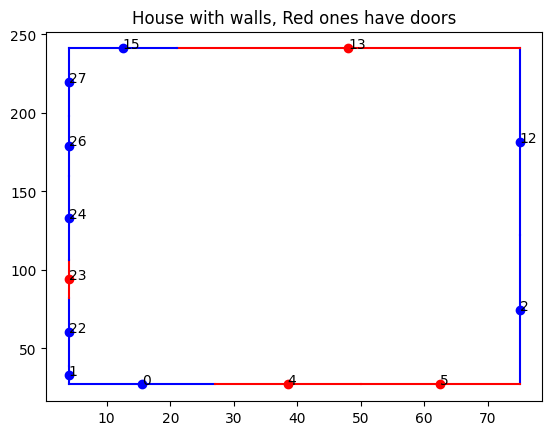

In [ ]:
house = 510
edges = np.array(data[house][2])[:,0:4]
doors = np.array(data[house][4])
rooms_coordinates = np.array(data[house][1])
rooms_connected = np.array(data[house][3], dtype=object)
rooms = np.array(data[house][0])
#TO DO: filter the broken graphs
#TO DO: randomize the input related to no of rooms
#TO DO: create files


fig, ax = plt.subplots()
ax.set_title("House with walls, Red ones have doors")
for elem in get_exterior_walls(rooms_connected, edges, doors):
  edge = elem[1]
  num = elem[0]
  x = np.array([edge[0], edge[2]])
  x_avg = np.mean(x)
  y = np.array([edge[1], edge[3]])
  y_avg = np.mean(y)
  if num in doors:
    ax.plot(x,y, "r")
    plt.scatter(x_avg, y_avg, c="#FF0000")
    plt.annotate(f"{elem[0]}", (x_avg, y_avg))
  else:
    ax.plot(x,y, "b")
    plt.scatter(x_avg, y_avg, c="#0000FF")
    plt.annotate(f"{elem[0]}", (x_avg, y_avg))

filter_graphs(rooms_connected, edges, doors)
# get_connection_corners(edges, rooms_connected)

# Plotting
# fig, ax = plt.subplots()
# ax.set_title("House with walls, Red ones have doors")
# for num, edge in enumerate(edges):
#   x = np.array([edge[0], edge[2]])
#   x_avg = np.mean(x)
#   y = np.array([edge[1], edge[3]])
#   y_avg = np.mean(y)
#   if num in doors:
#     ax.plot(x,y, "r")
#     plt.text(x_avg, y_avg, num)
#     plt.scatter(x_avg, y_avg, c="#FF0000")
#   else:
#     ax.plot(x,y, "b")
#     plt.text(x_avg, y_avg, num)
#     plt.scatter(x_avg, y_avg, c="#0000FF")
# for room_idx, room_type in enumerate(rooms_coordinates):
#   center_x = find_approximate_centroid(room_idx, edges, rooms_connected)[0]
#   center_y = find_approximate_centroid(room_idx, edges, rooms_connected)[1]
#   plt.text(center_x, center_y, room_idx)
#   plt.scatter(center_x-4, center_y+3, c="#000000")
# ax.set_aspect('equal')
# get_connection_rooms(rooms_connected, rooms_coordinates, rooms, edges, doors)

# get_number_of_bedrooms(rooms)
# for house in range(len(data)):
#   edges = np.array(data[house][2])[:,0:4]
#   doors = np.array(data[house][4])
#   rooms_coordinates = np.array(data[house][1])
#   rooms_connected = np.array(data[house][3], dtype=object)
#   rooms = np.array(data[house][0])
#   print(house, filter_graphs(rooms_connected, edges, doors))


In [ ]:
print(len(data))

145811


In [ ]:
import json
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        dtypes = (np.datetime64, np.complexfloating)
        if isinstance(obj, dtypes):
            return str(obj)
        elif isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            if any([np.issubdtype(obj.dtype, i) for i in dtypes]):
                return obj.astype(str).tolist()
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

In [ ]:
# import os
# import glob

# # Specify the folder path
# folder_path = '/content/user_inputs'

# # List all files in the folder
# files = glob.glob(os.path.join(folder_path, '*'))

# # Function to extract the number from a file name
# def extract_number(filename):
#     try:
#         return int(''.join(filter(str.isdigit, filename)))
#     except ValueError:
#         return -1  # Handle cases where there are no digits in the filename

# # Find the file with the highest number in its name
# max_file = max(files, key=extract_number, default=None)

# if max_file:
#     print(f"The file with the highest number is: {max_file}")
# else:
#     print("No files found in the folder.")

In [ ]:
#create the dict to remap the ids
#every key is a room_type
#every value is an array of integers
#the new id is the index of the old_id
ROOM_CLASS = {0:"exterior_wall", 1:"living_room", 2:"kitchen", 3:"bedroom", 4:"bathroom", 5:"missing", 6:"closet", 7:"balcony", 8:"corridor", 9:"dining_room", 10:"laundry_room"}
# house = 30654
# edges = np.array(data[house][2])[:,0:4]
# doors = np.array(data[house][4])
# rooms_coordinates = np.array(data[house][1])
# rooms_connected = np.array(data[house][3], dtype=object)
# rooms = np.array(data[house][0])
# exterior_walls = get_exterior_walls(rooms_connected, edges, doors)
def flatten_exterior_walls(exterior_walls):
  flattend_exterior_walls = []
  new_ids["exterior_wall"] = []
  for wall in exterior_walls:
    flat = []
    new_ids["exterior_wall"].append(wall[0])
    flat.append(new_ids["exterior_wall"].index(wall[0]))
    for elem in wall[1]:
      flat.append(elem)
    flat.append(wall[2])
    flattend_exterior_walls.append(flat)
  return flattend_exterior_walls

def get_corners_new_ids(connection_corners):
  new_corners = []
  for corner in connection_corners:
    corner[1] = new_ids["exterior_wall"].index(corner[1])
    corner[3] = new_ids["exterior_wall"].index(corner[3])
    new_corners.append(corner)
  return new_corners

def get_connection_rooms_new_ids(connection_rooms):
  new_connections = []
  for connection in connection_rooms:
    room_type_1 = ROOM_CLASS[connection[0]]
    room_id_1 = connection[1]
    if room_type_1 in new_ids:
      if room_id_1 in new_ids[room_type_1]:
        connection[1] = new_ids[room_type_1].index(room_id_1)
      else:
        new_ids[room_type_1].append(room_id_1)
        connection[1] = new_ids[room_type_1].index(room_id_1)
    else:
      new_ids[room_type_1] = [room_id_1]
      connection[1] = new_ids[room_type_1].index(room_id_1)

    room_type_2 = ROOM_CLASS[connection[2]]
    room_id_2 = connection[3]
    if room_type_2 in new_ids:
      if room_id_2 in new_ids[room_type_2]:
        connection[3] = new_ids[room_type_2].index(room_id_2)
      else:
        new_ids[room_type_2].append(room_id_2)
        connection[3] = new_ids[room_type_2].index(room_id_2)
    else:
      new_ids[room_type_2] = [room_id_2]
      connection[3] = new_ids[room_type_2].index(room_id_2)
    new_connections.append(connection)
  return new_connections

# new_ids = {}
# flattend_walls = flatten_exterior_walls(exterior_walls)
# connection_corners = get_connection_corners(edges, rooms_connected)
# get_corners_new_ids(connection_corners)
# connection_rooms = get_connection_rooms(rooms_connected, rooms_coordinates, rooms, edges, doors)
# print(*connection_rooms, sep="\n")
# print(len(connection_rooms))
# connection_rooms_new_ids = get_connection_rooms_new_ids(connection_rooms)
# print(*connection_rooms_new_ids, sep="\n")
# print(len(connection_rooms_new_ids))
# print(new_ids)






In [ ]:
# import os
# import json
# import networkx as nx
# import torch
# import pickle

# ROOM_CLASS = {0:"exterior_wall", 1:"living_room", 2:"kitchen", 3:"bedroom", 4:"bathroom", 5:"missing", 6:"closet", 7:"balcony", 8:"corridor", 9:"dining_room", 10:"laundry_room"}
# #only contains a part of the list
# #create the connection sequence associated with the partial graph
# class Node_custom:
#   def __init__(self, id, room_type):
#     self.id = id
#     self.room_type = room_type

#   def __hash__(self):
#       # Implement a custom hash method to make objects hashable
#       return hash((self.id, self.room_type))

#   def __eq__(self, other):
#       # Implement custom equality method to compare objects
#       return isinstance(other, Node_custom) and self.id == other.id and self.room_type == other.room_type

#   def __str__(self):
#     return f"{self.id} + {self.room_type}"

# def create_partial_graph(user_dict, new_ids):
#     G = nx.DiGraph()
#     partial_graph_data = user_dict["connections_rooms"]
#     # print(partial_graph_data)
#     for edge_conn in partial_graph_data:
#       old_id_src = new_ids[ROOM_CLASS[edge_conn[0]]][int(edge_conn[1])]
#       node_src = Node_custom(old_id_src, ROOM_CLASS[edge_conn[0]])
#       old_id_dest = new_ids[ROOM_CLASS[edge_conn[2]]][int(edge_conn[3])]
#       node_dest = Node_custom(old_id_dest, ROOM_CLASS[edge_conn[2]])
#       G.add_edge(node_src, node_dest, direction=int(edge_conn[5]), has_door=int(edge_conn[4]))

#     partial_graph_data = user_dict["connections_corners"]
#     for corner in partial_graph_data:
#       node_src = Node_custom(int(corner[1]), ROOM_CLASS[corner[0]])
#       node_dest = Node_custom(int(corner[3]), ROOM_CLASS[corner[2]])
#       G.add_edge(node_src, node_dest, angle = int(corner[4]))
#     return G

# def custom_sort_key(item):
#     # Sort first by 'type' (index 1), then by 'id' (index 0)
#     return (item.room_type, item.id)


# def sort_graph_nodes(G):
#   # sorted_types = ['balcony', 'bathroom', 'bedroom', 'closet', 'corridor', 'dining_room', 'exterior_wall', 'kitchen', 'laundry_room', 'living_room', 'missing']
#   sorted_nodes = sorted(G.nodes, key=custom_sort_key)
#   #as of python 3.7, python preserves insertion order
#   nodes_dict = {node: [] for node in sorted_nodes}
#   return nodes_dict

# def get_sequence_from_dict_partial(nodes_dict, new_ids):
#     sequence = []
#     for node_src in nodes_dict.keys():
#       if node_src.room_type != "exterior_wall":
#         while len(nodes_dict[node_src]) != 0:
#           node_dest = nodes_dict[node_src].pop()
#           sequence.append((1,0,-1))
#           if node_dest[0].room_type in new_ids:
#             if node_dest[0].id in new_ids[node_dest[0].room_type]:
#               node_dest_id = new_ids[node_dest[0].room_type].index(node_dest[0].id)
#             else:
#               new_ids[node_dest[0].room_type].append(node_dest[0].id)
#               node_dest_id = new_ids[node_dest[0].room_type].index(node_dest[0].id)
#           else:
#             new_ids[node_dest[0].room_type] = [node_dest[0].id]
#             node_dest_id = new_ids[node_dest[0].room_type].index(node_dest[0].id)
#           print(f"SRC:type:{node_src.room_type}, id:{node_src.id}")
#           print(f"DEST: {(2,(node_dest[0].room_type, node_dest_id), torch.tensor([[node_dest[1], node_dest[2]]]))}")
#           sequence.append((2,(node_dest[0].room_type, node_dest_id), torch.tensor([[node_dest[1], node_dest[2]]])))
#         sequence.append((1,1,-1))
#     sequence.append((0, "stop", -1))
#     return sequence


# def complete_partial_graph(G, data, house):
#     edges = np.array(data[house][2])[:,0:4]
#     doors = np.array(data[house][4])
#     rooms_coordinates = np.array(data[house][1])
#     rooms_connected = np.array(data[house][3], dtype=object)
#     rooms = np.array(data[house][0])

#     nodes_dict = sort_graph_nodes(G)
#     for index, connection in enumerate(rooms_connected):
#       if len(connection) == 1:
#         room1 = connection[0]
#         room_type = ROOM_CLASS[rooms[room1]]
#         node_src = Node_custom(room1, room_type)
#         if node_src in nodes_dict:
#           node_dest = Node_custom(index, "exterior_wall")
#           has_door = int(1) if index in doors else int(0)
#           #find the direction
#           room1_middle = find_approximate_centroid(room1, edges, rooms_connected)
#           wall1_middle = get_middle_of_room(edges[index])
#           direction = get_cardinal_location(room1_middle, wall1_middle)
#           if not G.has_edge(node_src, node_dest):
#             # print(f"node_src: {node_src}, node_dest: {node_dest}")
#             nodes_dict.get(node_src).append((node_dest, has_door, direction))
#             G.add_edge(node_src, node_dest, has_door = has_door, direction = direction)
#       if len(connection) == 2:
#         room1 = connection[0]
#         room_type_1 = ROOM_CLASS[rooms[room1]]
#         node_src = Node_custom(room1, room_type_1)
#         room1_middle = find_approximate_centroid(room1, edges, rooms_connected)
#         room2 = connection[1]
#         room_type_2 = ROOM_CLASS[rooms[room2]]
#         node_dest = Node_custom(room2, room_type_2)
#         room2_middle = find_approximate_centroid(room2, edges, rooms_connected)
#         has_door = int(1) if index in doors else int(0)
#         if node_src in nodes_dict and node_dest in nodes_dict and node_src != node_dest and not G.has_edge(node_src, node_dest):
#           # print(f"node_src: {node_src}, node_dest: {node_dest}")
#           direction = get_cardinal_location(room1_middle, room2_middle)
#           nodes_dict.get(node_src).append((node_dest, has_door, direction))
#           G.add_edge(node_src, node_dest, has_door = has_door, direction = direction)


#     sequence = get_sequence_from_dict_partial(nodes_dict, new_ids)
#     return sequence

# def inv_dir(direction):
#   if direction == 8:
#     inv_dir = 8
#   else:
#     inv_dir = (direction + 4) % 8
#   return inv_dir

# def get_sequence_from_complete_graph(nodes_dict, new_ids):
#     sequence = []
#     for node_src in nodes_dict.keys():
#       if node_src.room_type != "exterior_wall":
#         while len(nodes_dict[node_src]) != 0:
#           if None in nodes_dict[node_src]:
#             sequence.append((0, node_src.room_type , -1))
#             nodes_dict[node_src].pop(nodes_dict[node_src].index(None))
#           else:
#             node_dest = nodes_dict[node_src].pop()
#             if not None in nodes_dict.get(node_dest[0], []):
#               sequence.append((1,0,-1))
#               if node_dest[0].room_type in new_ids:
#                 if node_dest[0].id in new_ids[node_dest[0].room_type]:
#                   node_dest_id = new_ids[node_dest[0].room_type].index(node_dest[0].id)
#                 else:
#                   new_ids[node_dest[0].room_type].append(node_dest[0].id)
#                   node_dest_id = new_ids[node_dest[0].room_type].index(node_dest[0].id)
#               else:
#                 new_ids[node_dest[0].room_type] = [node_dest[0].id]
#                 node_dest_id = new_ids[node_dest[0].room_type].index(node_dest[0].id)
#               sequence.append((2,(node_dest[0].room_type, node_dest_id), torch.tensor([[node_dest[1], node_dest[2]]])))
#             else:
#               # print(node_src)
#               nodes_dict[node_dest[0]].append((node_src, node_dest[1], inv_dir(node_dest[2])))
#         sequence.append((1,1,-1))

#     sequence.append((0, "stop", -1))
#     return sequence





# def complete_graph(G, data, house):
#     edges = np.array(data[house][2])[:,0:4]
#     doors = np.array(data[house][4])
#     rooms_coordinates = np.array(data[house][1])
#     rooms_connected = np.array(data[house][3], dtype=object)
#     rooms = np.array(data[house][0])
#     nodes_dict = sort_graph_nodes(G)
#     for index, connection in enumerate(rooms_connected):
#       if len(connection) == 1:
#         room1 = connection[0]
#         room_type = ROOM_CLASS[rooms[room1]]
#         node_src = Node_custom(room1, room_type)
#         node_dest = Node_custom(index, "exterior_wall")
#         has_door = int(1) if index in doors else int(0)
#           #find the direction
#         room1_middle = find_approximate_centroid(room1, edges, rooms_connected)
#         wall1_middle = get_middle_of_room(edges[index])
#         direction = get_cardinal_location(room1_middle, wall1_middle)
#         #here we should not have existing nodes that are not connected to the exterior walls
#         #we create a key for this new node and we add a none to its value list, meaning that we have to add this node in the sequence
#         if node_src not in nodes_dict:
#           nodes_dict[node_src] = [None]
#           nodes_dict[node_src].append((node_dest, has_door, direction))
#           G.add_edge(node_src, node_dest, has_door = has_door, direction = direction)
#       if len(connection) == 2:
#         room1 = connection[0]
#         room_type_1 = ROOM_CLASS[rooms[room1]]
#         node_src = Node_custom(room1, room_type_1)
#         room1_middle = find_approximate_centroid(room1, edges, rooms_connected)
#         room2 = connection[1]
#         room_type_2 = ROOM_CLASS[rooms[room2]]
#         node_dest = Node_custom(room2, room_type_2)
#         room2_middle = find_approximate_centroid(room2, edges, rooms_connected)
#         has_door = int(1) if index in doors else int(0)
#         if node_src not in nodes_dict:
#           nodes_dict[node_src] = [None]
#         if node_dest not in nodes_dict:
#           nodes_dict[node_dest] = [None]
#         if not G.has_edge(node_src, node_dest):
#           direction = get_cardinal_location(room1_middle, room2_middle)
#           nodes_dict.get(node_src).append((node_dest, has_door, direction))
#           G.add_edge(node_src, node_dest, has_door = has_door, direction = direction)

#     sequence = get_sequence_from_complete_graph(nodes_dict, new_ids)
#     return sequence



# def get_sequences(rootdir, data):
#     partial_sequences = {}
#     completed_sequences = {}
#     i = 0
#     for entry in os.scandir(rootdir):
#       file_path = entry.path
#       file_name = entry.name
#       house = int(file_name[:-5])
#       print(house)
#       i += 1
#       print(i)
#       with open(file_path) as f:
#         user_dict = json.load(f)
#         G = create_partial_graph(user_dict, new_ids)
#         partial_sequences[house] = complete_partial_graph(G, data, house)
#         completed_sequences[house] = complete_graph(G, data, house)
#       # print(partial_sequences[house])
#       # print(completed_sequences[house])

#     # Store data (serialize)
#     with open('partial_graphs.pickle', 'wb') as handle:
#       pickle.dump(partial_sequences, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     with open('completed_graphs.pickle', 'wb') as handle:
#       pickle.dump(completed_sequences, handle, protocol=pickle.HIGHEST_PROTOCOL)
#         # node_labels = {node: str(node) for node in G.nodes}
#         # pos = nx.spring_layout(G, seed=47)  # Seed layout for reproducibility
#         # nx.draw(G, pos=pos, with_labels=True, labels=node_labels)
#         # plt.show()


#             #case 1 - ignore this case for now: has both nodes -> (1, 0, -1)
#             #case 2: has 1 of the nodes -> (0, node_type_missing, -1)
#             #case 3: has none of the nodes ->
#           #add edge with door
#         # break


# # rootdir = '/content/user_inputs_25_10/content/user_inputs_list_25_10'
# # data = np.load("/content/drive/MyDrive/IAAIP/dataset/housegan_clean_data.npy", None, True)
# # get_sequences(rootdir, data)


In [ ]:
import os
import json
import networkx as nx
import torch
import pickle
import random

ROOM_CLASS = {0:"exterior_wall", 1:"living_room", 2:"kitchen", 3:"bedroom", 4:"bathroom", 5:"missing", 6:"closet", 7:"balcony", 8:"corridor", 9:"dining_room", 10:"laundry_room"}
#only contains a part of the list
#create the connection sequence associated with the partial graph
class Node_custom:
  def __init__(self, id, room_type):
    self.id = id
    self.room_type = room_type

  def __hash__(self):
      # Implement a custom hash method to make objects hashable
      return hash((self.id, self.room_type))

  def __eq__(self, other):
      # Implement custom equality method to compare objects
      return isinstance(other, Node_custom) and self.id == other.id and self.room_type == other.room_type

  def __str__(self):
    return f"{self.id} + {self.room_type}"

#based on connection_rooms and connection_corners from the user_dict, i create the partial graph
def create_partial_graph(user_dict):
    G = nx.DiGraph()
    #connections_rooms uses the new_ids!
    partial_graph_data = user_dict["connections_rooms"]
    for edge_conn in partial_graph_data:
      node_src = Node_custom(edge_conn[1], ROOM_CLASS[edge_conn[0]])
      node_dest = Node_custom(edge_conn[3], ROOM_CLASS[edge_conn[2]])
      G.add_edge(node_src, node_dest, direction=int(edge_conn[5]), has_door=int(edge_conn[4]))
    partial_graph_data = user_dict["connections_corners"]
    for corner in partial_graph_data:
      node_src = Node_custom(int(corner[1]), ROOM_CLASS[corner[0]])
      node_dest = Node_custom(int(corner[3]), ROOM_CLASS[corner[2]])
      G.add_edge(node_src, node_dest, angle = int(corner[4]))
    return G

def custom_sort_key(item):
    # Sort first by 'type' (index 1), then by 'id' (index 0)
    return (item.room_type, item.id)

def sort_graph_nodes(G):
  # sorted_types = ['balcony', 'bathroom', 'bedroom', 'closet', 'corridor', 'dining_room', 'exterior_wall', 'kitchen', 'laundry_room', 'living_room', 'missing']
  sorted_nodes = sorted(G.nodes, key=custom_sort_key)
  #as of python 3.7, python preserves insertion order
  nodes_dict = {node: [] for node in sorted_nodes}
  return nodes_dict

#there are edges that have been not specified by the user, but should be added to the partial graph
def complete_partial_graph(G, data, house):
    edges = np.array(data[house][2])[:,0:4]
    doors = np.array(data[house][4])
    rooms_coordinates = np.array(data[house][1])
    rooms_connected = np.array(data[house][3], dtype=object)
    rooms = np.array(data[house][0])

    nodes_dict = sort_graph_nodes(G)
    for index, connection in enumerate(rooms_connected):
      if len(connection) == 1:
        #this uses the old id
        room1 = connection[0]
        room_type = ROOM_CLASS[rooms[room1]]
        #this means that it was already seen and added to the graph
        if room1 in new_ids.get(room_type, []):
          room1_new_id = new_ids[room_type].index(room1)
          node_src = Node_custom(room1_new_id, room_type)
          if node_src in nodes_dict:
            node_dest = Node_custom(new_ids["exterior_wall"].index(index), "exterior_wall")
            has_door = int(1) if index in doors else int(0)
            #find the direction
            room1_middle = find_approximate_centroid(room1, edges, rooms_connected)
            wall1_middle = get_middle_of_room(edges[index])
            direction = get_cardinal_location(room1_middle, wall1_middle)
            if not G.has_edge(node_src, node_dest):
              nodes_dict.get(node_src).append((node_dest, has_door, direction))
              G.add_edge(node_src, node_dest, has_door = has_door, direction = direction)
            else:
              if has_door and (node_dest, False, direction) in nodes_dict[node_src]:
                G[node_src][node_dest]["has_door"] = has_door
                nodes_dict[node_src].remove((node_dest, False, direction))
                nodes_dict[node_src].append((node_dest, has_door, direction))
      if len(connection) == 2:
        if connection[0] != connection[1]:
          room1 = connection[0]
          room_type_1 = ROOM_CLASS[rooms[room1]]
          room2 = connection[1]
          room_type_2 = ROOM_CLASS[rooms[room2]]
          if room1 in new_ids.get(room_type_1, []) and room2 in new_ids.get(room_type_2, []):
            node_src = Node_custom(new_ids.get(room_type_1).index(room1), room_type_1)
            room1_middle = find_approximate_centroid(room1, edges, rooms_connected)
            node_dest = Node_custom(new_ids.get(room_type_2).index(room2), room_type_2)
            room2_middle = find_approximate_centroid(room2, edges, rooms_connected)
            has_door = int(1) if index in doors else int(0)
            direction = get_cardinal_location(room1_middle, room2_middle)
            if node_src in nodes_dict and node_dest in nodes_dict and node_src != node_dest and not G.has_edge(node_src, node_dest):
              # print(f"node_src: {node_src}, node_dest: {node_dest}")
              nodes_dict.get(node_src).append((node_dest, has_door, direction))
              G.add_edge(node_src, node_dest, has_door = has_door, direction = direction)
            elif G.has_edge(node_src, node_dest):
              if has_door and (node_dest, False, direction) in nodes_dict[node_src]:
                G[node_src][node_dest]["has_door"] = has_door
                nodes_dict[node_src].remove((node_dest, False, direction))
                nodes_dict[node_src].append((node_dest, has_door, direction))

    sequence = get_sequence_from_dict_partial(nodes_dict)
    return sequence


def get_sequence_from_dict_partial(nodes_dict):
    sequence = []
    for node_src in nodes_dict.keys():
      if node_src.room_type != "exterior_wall":
        while len(nodes_dict[node_src]) != 0:
          node_dest = nodes_dict[node_src].pop()
          sequence.append((1,0,-1))
          # print(f"SRC:type:{node_src.room_type}, id:{node_src.id}")
          # print(f"DEST: {(2,(node_dest[0].room_type, node_dest[0].id), torch.tensor([[node_dest[1], node_dest[2]]]))}")
          sequence.append((2,(node_dest[0].room_type, node_dest[0].id), torch.tensor([[node_dest[1], node_dest[2]]])))
        sequence.append((1,1,-1))
    sequence.append((0, "stop", -1))
    return sequence

def inv_dir(direction):
  if direction == 8:
    inv_dir = 8
  else:
    inv_dir = (direction + 4) % 8
  return inv_dir


def complete_graph(G, data, house):
    edges = np.array(data[house][2])[:,0:4]
    doors = np.array(data[house][4])
    rooms_coordinates = np.array(data[house][1])
    rooms_connected = np.array(data[house][3], dtype=object)
    rooms = np.array(data[house][0])
    nodes_dict = sort_graph_nodes(G)
    for index, connection in enumerate(rooms_connected):
      if len(connection) == 1:
        room1 = connection[0]
        room_type = ROOM_CLASS[rooms[room1]]
        if not room1 in new_ids.get(room_type, []):
          if room_type not in new_ids:
            new_ids[room_type] = []
          new_ids[room_type].append(room1)
        room1_new_id = new_ids[room_type].index(room1)
        node_src = Node_custom(room1_new_id, room_type)
        node_dest = Node_custom(new_ids["exterior_wall"].index(index), "exterior_wall")
        has_door = int(1) if index in doors else int(0)
        room1_middle = find_approximate_centroid(room1, edges, rooms_connected)
        wall1_middle = get_middle_of_room(edges[index])
        direction = get_cardinal_location(room1_middle, wall1_middle)
        #if it is not in the dict, it is also not in the graph
        if node_src not in nodes_dict:
          nodes_dict[node_src] = [None]
        if not G.has_edge(node_src, node_dest):
          nodes_dict[node_src].append((node_dest, has_door, direction))
          G.add_edge(node_src, node_dest, has_door = has_door, direction = direction)
        else:
          if has_door and (node_dest, False, direction) in nodes_dict[node_src]:
            G[node_src][node_dest]["has_door"] = has_door
            nodes_dict[node_src].remove((node_dest, False, direction))
            nodes_dict[node_src].append((node_dest, has_door, direction))


      if len(connection) == 2:
        if connection[0] != connection[1]:
          room1 = connection[0]
          room_type_1 = ROOM_CLASS[rooms[room1]]
          if not room1 in new_ids.get(room_type_1, []):
            if room_type_1 not in new_ids:
              new_ids[room_type_1] = []
            new_ids[room_type_1].append(room1)
          room1_new_id = new_ids[room_type_1].index(room1)
          node_src = Node_custom(room1_new_id, room_type_1)
          room1_middle = find_approximate_centroid(room1, edges, rooms_connected)
          room2 = connection[1]
          room_type_2 = ROOM_CLASS[rooms[room2]]
          if not room2 in new_ids.get(room_type_2, []):
            if room_type_2 not in new_ids:
              new_ids[room_type_2] = []
            new_ids[room_type_2].append(room2)
          room2_new_id = new_ids[room_type_2].index(room2)
          node_dest = Node_custom(room2_new_id, room_type_2)
          room2_middle = find_approximate_centroid(room2, edges, rooms_connected)
          has_door = int(1) if index in doors else int(0)
          if node_src not in nodes_dict:
            nodes_dict[node_src] = [None]
          if node_dest not in nodes_dict:
            nodes_dict[node_dest] = [None]
          direction = get_cardinal_location(room1_middle, room2_middle)
          if not G.has_edge(node_src, node_dest):
            nodes_dict.get(node_src).append((node_dest, has_door, direction))
            G.add_edge(node_src, node_dest, has_door = has_door, direction = direction)
          else:
            if has_door and (node_dest, False, direction) in nodes_dict[node_src]:
              G[node_src][node_dest]["has_door"] = has_door
              nodes_dict[node_src].remove((node_dest, False, direction))
              nodes_dict[node_src].append((node_dest, has_door, direction))

    # if len(list(nx.nodes_with_selfloops(G))) > 0:
    #   for node in list(nx.nodes_with_selfloops(G)):
    #     for i, elem in enumerate(nodes_dict[node]):
    #       if elem == node:
    #         nodes_dict[node].pop(i)
    #   G.remove_edges_from(nx.selfloop_edges(G))

    sequence = get_sequence_from_complete_graph(nodes_dict)
    return sequence

def get_sequence_from_complete_graph(nodes_dict):
    sequence = []
    for node_src in list(nodes_dict.keys()):
      if None in nodes_dict[node_src]:
        sequence.append((0, node_src.room_type , -1))
        nodes_dict[node_src].pop(nodes_dict[node_src].index(None))
        for elem_dest in nodes_dict[node_src]:
          node_dest = elem_dest[0]
          if None in nodes_dict[node_dest]:
            nodes_dict[node_dest].append((node_src, elem_dest[1], inv_dir(elem_dest[2])))
          else:
            sequence.append((1,0,-1))
            # print(f"SRC:type:{node_src.room_type}, id:{node_src.id}")
            # print(f"DEST: {(2,(node_dest.room_type, node_dest.id), torch.tensor([[elem_dest[1], elem_dest[2]]]))}")
            sequence.append((2,(node_dest.room_type, node_dest.id), torch.tensor([[elem_dest[1], elem_dest[2]]])))
        sequence.append((1,1,-1))
      else:
        for elem_dest in nodes_dict[node_src]:
          node_dest = elem_dest[0]
          nodes_dict[node_dest].append((node_src, elem_dest[1], inv_dir(elem_dest[2])))
    sequence.append((0, "stop", -1))
    return sequence











In [ ]:
import json

!mkdir user_inputs_new_ids

# data = np.load("/content/drive/MyDrive/IAAIP/dataset/housegan_clean_data.npy", None, True)
first_house = 0
last_house = len(data)
partial_sequences = {}
completed_sequences = {}
for house in range(first_house, last_house):
  new_ids = {}
  print(f"house:{house}")
  user_dict = {}
  if house!=145334 and house!=142750 and house!=138712 and house!=138018 and house!=129928 and house!=121403 and house!=113553 and house!=107748 and house!=101238 and house!=100464 and house!=285 and house!=8353 and house!=30378 and house!=33226 and house!=37003 and house!=37775 and house!=49822 and house!=51691 and house!=59508 and house!=59824 and house!=63784 and house!=67842 and house!=75349 and house!=77302 and house!=77913 and house!=85357 and house!=87460 and house!=88646 and house!=91354 and house!=95675:
    edges = np.array(data[house][2])[:,0:4]
    doors = np.array(data[house][4])
    rooms_coordinates = np.array(data[house][1])
    rooms_connected = np.array(data[house][3], dtype=object)
    rooms = np.array(data[house][0])
    if filter_graphs(rooms_connected, edges, doors):
      living_rooms = get_number_of_living_rooms(rooms)
      bedrooms = get_number_of_bedrooms(rooms)
      bathrooms = get_number_of_bathrooms(rooms)
      user_dict = {"number_of_living_rooms": living_rooms[0],
                  "living_rooms_plus?": living_rooms[1],
                  "number_of_bedrooms": bedrooms[0],
                  "bedrooms_plus?": bedrooms[1],
                  "number_of_bathrooms": bathrooms[0],
                  "bathrooms_plus?": bathrooms[1],
                  "exterior_walls": flatten_exterior_walls(get_exterior_walls(rooms_connected, edges, doors)),
                  "connections_corners": get_corners_new_ids(get_connection_corners(edges, rooms_connected)),
                  "connections_rooms": get_connection_rooms_new_ids(get_connection_rooms(rooms_connected, rooms_coordinates, rooms, edges, doors))
                  }

      with open(f"/content/user_inputs_new_ids/{house}.json", "w") as f:
        json.dump(user_dict, f, indent = 2, cls=NpEncoder, separators=(',', ':'))
      G = create_partial_graph(user_dict)
      partial_sequences[house] = complete_partial_graph(G, data, house)
      completed_sequences[house] = complete_graph(G, data, house)


with open('partial_graphs.pickle', 'wb') as handle:
  pickle.dump(list(partial_sequences.values()), handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('completed_graphs.pickle', 'wb') as handle:
  pickle.dump(list(completed_sequences.values()), handle, protocol=pickle.HIGHEST_PROTOCOL)




Streaming output truncated to the last 5000 lines.
house:2919
house:2920
house:2921
house:2922
house:2923
house:2924
house:2925
house:2926
house:2927
house:2928
house:2929
house:2930
house:2931
house:2932
house:2933
house:2934
house:2935
house:2936
house:2937
house:2938
house:2939
house:2940
house:2941
house:2942
house:2943
house:2944
house:2945
house:2946
house:2947
house:2948
house:2949
house:2950
house:2951
house:2952
house:2953
house:2954
house:2955
house:2956
house:2957
house:2958
house:2959
house:2960
house:2961
house:2962
house:2963
house:2964
house:2965
house:2966
house:2967
house:2968
house:2969
house:2970
house:2971
house:2972
house:2973
house:2974
house:2975
house:2976
house:2977
house:2978
house:2979
house:2980
house:2981
house:2982
house:2983
house:2984
house:2985
house:2986
house:2987
house:2988
house:2989
house:2990
house:2991
house:2992
house:2993
house:2994
house:2995
house:2996
house:2997
house:2998
house:2999
house:3000
house:3001
house:3002
house:3003
house:3004
hou

KeyboardInterrupt: ignored

In [ ]:
!zip -r /content/user_inputs_new_ids user_inputs_new_ids

updating: user_inputs_new_ids/ (stored 0%)
updating: user_inputs_new_ids/0.json (deflated 84%)
updating: user_inputs_new_ids/8.json (deflated 84%)
updating: user_inputs_new_ids/3.json (deflated 86%)
updating: user_inputs_new_ids/1.json (deflated 85%)
updating: user_inputs_new_ids/7.json (deflated 86%)
updating: user_inputs_new_ids/5.json (deflated 86%)
updating: user_inputs_new_ids/6.json (deflated 84%)
updating: user_inputs_new_ids/4.json (deflated 85%)
updating: user_inputs_new_ids/9.json (deflated 85%)
  adding: user_inputs_new_ids/32.json (deflated 85%)
  adding: user_inputs_new_ids/26.json (deflated 87%)
  adding: user_inputs_new_ids/44.json (deflated 86%)
  adding: user_inputs_new_ids/11.json (deflated 77%)
  adding: user_inputs_new_ids/16.json (deflated 83%)
  adding: user_inputs_new_ids/43.json (deflated 85%)
  adding: user_inputs_new_ids/19.json (deflated 86%)
  adding: user_inputs_new_ids/27.json (deflated 87%)
  adding: user_inputs_new_ids/10.json (deflated 85%)
  adding: us

In [ ]:
# !unzip /content/drive/MyDrive/IAAIP/dataset/user_inputs_25_10.zip -d user_inputs_25_10

In [ ]:
# import os
# import json
# import networkx as nx
# import torch
# import pickle

# ROOM_CLASS = {0:"exterior_wall", 1:"living_room", 2:"kitchen", 3:"bedroom", 4:"bathroom", 5:"missing", 6:"closet", 7:"balcony", 8:"corridor", 9:"dining_room", 10:"laundry_room"}
# #only contains a part of the list
# #create the connection sequence associated with the partial graph
# class Node_custom:
#   def __init__(self, id, room_type):
#     self.id = id
#     self.room_type = room_type

#   def __hash__(self):
#       # Implement a custom hash method to make objects hashable
#       return hash((self.id, self.room_type))

#   def __eq__(self, other):
#       # Implement custom equality method to compare objects
#       return isinstance(other, Node_custom) and self.id == other.id and self.room_type == other.room_type

#   def __str__(self):
#     return f"{self.id} + {self.room_type}"

# def create_partial_graph(user_dict):
#     G = nx.DiGraph()
#     partial_graph_data = user_dict["connections_rooms"]
#     # print(partial_graph_data)
#     for edge_conn in partial_graph_data:
#       node_src = Node_custom(int(edge_conn[1]), ROOM_CLASS[edge_conn[0]])
#       node_dest = Node_custom(int(edge_conn[3]), ROOM_CLASS[edge_conn[2]])
#       G.add_edge(node_src, node_dest, direction=int(edge_conn[5]), has_door=int(edge_conn[4]))

#     partial_graph_data = user_dict["connections_corners"]
#     for corner in partial_graph_data:
#       node_src = Node_custom(int(corner[1]), ROOM_CLASS[corner[0]])
#       node_dest = Node_custom(int(corner[3]), ROOM_CLASS[corner[2]])
#       G.add_edge(node_src, node_dest, angle = int(corner[4]))
#     return G

# def custom_sort_key(item):
#     # Sort first by 'type' (index 1), then by 'id' (index 0)
#     return (item.room_type, item.id)


# def sort_graph_nodes(G):
#   # sorted_types = ['balcony', 'bathroom', 'bedroom', 'closet', 'corridor', 'dining_room', 'exterior_wall', 'kitchen', 'laundry_room', 'living_room', 'missing']
#   sorted_nodes = sorted(G.nodes, key=custom_sort_key)
#   #as of python 3.7, python preserves insertion order
#   nodes_dict = {node: [] for node in sorted_nodes}
#   return nodes_dict

# def get_sequence_from_dict_partial(nodes_dict):
#     sequence = []
#     for node_src in nodes_dict.keys():
#       if node_src.room_type != "exterior_wall":
#         while len(nodes_dict[node_src]) != 0:
#           node_dest = nodes_dict[node_src].pop()
#           sequence.append((1,0,-1))
#           sequence.append((2,(node_dest[0].room_type, node_dest[0].id), torch.tensor([[node_dest[1], node_dest[2]]])))
#         sequence.append((1,1,-1))
#     sequence.append((0, "stop", -1))
#     return sequence


# def complete_partial_graph(G, data, house):
#     edges = np.array(data[house][2])[:,0:4]
#     doors = np.array(data[house][4])
#     rooms_coordinates = np.array(data[house][1])
#     rooms_connected = np.array(data[house][3], dtype=object)
#     rooms = np.array(data[house][0])

#     nodes_dict = sort_graph_nodes(G)
#     for index, connection in enumerate(rooms_connected):
#       if len(connection) == 1:
#         room1 = connection[0]
#         room_type = ROOM_CLASS[rooms[room1]]
#         node_src = Node_custom(room1, room_type)
#         if node_src in nodes_dict:
#           node_dest = Node_custom(index, "exterior_wall")
#           has_door = int(1) if index in doors else int(0)
#           #find the direction
#           room1_middle = find_approximate_centroid(room1, edges, rooms_connected)
#           wall1_middle = get_middle_of_room(edges[index])
#           direction = get_cardinal_location(room1_middle, wall1_middle)
#           if not G.has_edge(node_src, node_dest):
#             # print(f"node_src: {node_src}, node_dest: {node_dest}")
#             nodes_dict.get(node_src).append((node_dest, has_door, direction))
#             G.add_edge(node_src, node_dest, has_door = has_door, direction = direction)
#       if len(connection) == 2:
#         room1 = connection[0]
#         room_type_1 = ROOM_CLASS[rooms[room1]]
#         node_src = Node_custom(room1, room_type_1)
#         room1_middle = find_approximate_centroid(room1, edges, rooms_connected)
#         room2 = connection[1]
#         room_type_2 = ROOM_CLASS[rooms[room2]]
#         node_dest = Node_custom(room2, room_type_2)
#         room2_middle = find_approximate_centroid(room2, edges, rooms_connected)
#         has_door = int(1) if index in doors else int(0)
#         if node_src in nodes_dict and node_dest in nodes_dict and node_src != node_dest and not G.has_edge(node_src, node_dest):
#           # print(f"node_src: {node_src}, node_dest: {node_dest}")
#           direction = get_cardinal_location(room1_middle, room2_middle)
#           nodes_dict.get(node_src).append((node_dest, has_door, direction))
#           G.add_edge(node_src, node_dest, has_door = has_door, direction = direction)


#     sequence = get_sequence_from_dict_partial(nodes_dict)
#     return sequence

# def inv_dir(direction):
#   if direction == 8:
#     inv_dir = 8
#   else:
#     inv_dir = (direction + 4) % 8
#   return inv_dir

# def get_sequence_from_complete_graph(nodes_dict):
#     sequence = []
#     for node_src in nodes_dict.keys():
#       if node_src.room_type != "exterior_wall":
#         while len(nodes_dict[node_src]) != 0:
#           if None in nodes_dict[node_src]:
#             sequence.append((0, node_src.room_type , -1))
#             nodes_dict[node_src].pop(nodes_dict[node_src].index(None))
#           else:
#             node_dest = nodes_dict[node_src].pop()
#             if not None in nodes_dict[node_dest[0]]:
#               sequence.append((1,0,-1))
#               sequence.append((2,(node_dest[0].room_type, node_dest[0].id), torch.tensor([[node_dest[1], node_dest[2]]])))
#             else:
#               # print(node_src)
#               nodes_dict[node_dest[0]].append((node_src, node_dest[1], inv_dir(node_dest[2])))
#         sequence.append((1,1,-1))

#     sequence.append((0, "stop", -1))
#     return sequence





# def complete_graph(G, data, house):
#     edges = np.array(data[house][2])[:,0:4]
#     doors = np.array(data[house][4])
#     rooms_coordinates = np.array(data[house][1])
#     rooms_connected = np.array(data[house][3], dtype=object)
#     rooms = np.array(data[house][0])
#     nodes_dict = sort_graph_nodes(G)
#     for index, connection in enumerate(rooms_connected):
#       if len(connection) == 1:
#         room1 = connection[0]
#         room_type = ROOM_CLASS[rooms[room1]]
#         node_src = Node_custom(room1, room_type)
#         node_dest = Node_custom(index, "exterior_wall")
#         has_door = int(1) if index in doors else int(0)
#           #find the direction
#         room1_middle = find_approximate_centroid(room1, edges, rooms_connected)
#         wall1_middle = get_middle_of_room(edges[index])
#         direction = get_cardinal_location(room1_middle, wall1_middle)
#         #here we should not have existing nodes that are not connected to the exterior walls
#         #we create a key for this new node and we add a none to its value list, meaning that we have to add this node in the sequence
#         if node_src not in nodes_dict:
#           nodes_dict[node_src] = [None]
#           nodes_dict[node_src].append((node_dest, has_door, direction))
#           G.add_edge(node_src, node_dest, has_door = has_door, direction = direction)
#       if len(connection) == 2:
#         room1 = connection[0]
#         room_type_1 = ROOM_CLASS[rooms[room1]]
#         node_src = Node_custom(room1, room_type_1)
#         room1_middle = find_approximate_centroid(room1, edges, rooms_connected)
#         room2 = connection[1]
#         room_type_2 = ROOM_CLASS[rooms[room2]]
#         node_dest = Node_custom(room2, room_type_2)
#         room2_middle = find_approximate_centroid(room2, edges, rooms_connected)
#         has_door = int(1) if index in doors else int(0)
#         if node_src not in nodes_dict:
#           nodes_dict[node_src] = [None]
#         if node_dest not in nodes_dict:
#           nodes_dict[node_dest] = [None]
#         if not G.has_edge(node_src, node_dest):
#           direction = get_cardinal_location(room1_middle, room2_middle)
#           nodes_dict.get(node_src).append((node_dest, has_door, direction))
#           G.add_edge(node_src, node_dest, has_door = has_door, direction = direction)

#     sequence = get_sequence_from_complete_graph(nodes_dict)
#     return sequence



# def get_sequences(rootdir, data):
#     partial_sequences = {}
#     completed_sequences = {}
#     i = 0
#     for entry in os.scandir(rootdir):
#       file_path = entry.path
#       file_name = entry.name
#       house = int(file_name[:-5])
#       print(house)
#       i += 1
#       print(i)
#       with open(file_path) as f:
#         user_dict = json.load(f)
#         G = create_partial_graph(user_dict)
#         partial_sequences[house] = complete_partial_graph(G, data, house)
#         completed_sequences[house] = complete_graph(G, data, house)
#       # print(partial_sequences[house])
#       # print(completed_sequences[house])

#     # Store data (serialize)
#     with open('partial_graphs.pickle', 'wb') as handle:
#       pickle.dump(partial_sequences, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     with open('completed_graphs.pickle', 'wb') as handle:
#       pickle.dump(completed_sequences, handle, protocol=pickle.HIGHEST_PROTOCOL)
#         # node_labels = {node: str(node) for node in G.nodes}
#         # pos = nx.spring_layout(G, seed=47)  # Seed layout for reproducibility
#         # nx.draw(G, pos=pos, with_labels=True, labels=node_labels)
#         # plt.show()


#             #case 1 - ignore this case for now: has both nodes -> (1, 0, -1)
#             #case 2: has 1 of the nodes -> (0, node_type_missing, -1)
#             #case 3: has none of the nodes ->
#           #add edge with door
#         # break


# rootdir = '/content/user_inputs_25_10/content/user_inputs_list_25_10'
# # data = np.load("/content/drive/MyDrive/IAAIP/dataset/housegan_clean_data.npy", None, True)
# get_sequences(rootdir, data)
